# Masterarbeit (Batch-Tool)

In [1]:
# Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

#Use notebook for interactive plots
#%matplotlib notebook
%matplotlib inline

In [2]:
# JSON Lib
! pip install demjson
import demjson

In [3]:
# Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# WordCloud
! pip install wordcloud
from wordcloud import WordCloud

In [5]:
# Show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Dateien ausgeben und Variablen setzen
dir_var = "../"
! ls -al ../

total 32
drwxr-xr-x 10 jovyan users   320 Dec 11 14:25 .
drwsrwsr-x  1 jovyan users  4096 Dec 12 15:11 ..
drwxr-xr-x 33 jovyan users  1056 Dec 11 14:25 DS-08-10-2020
drwxr-xr-x 18 jovyan users   576 Dec 11 14:25 DS-22-10-2020
drwxr-xr-x 14 jovyan users   448 Dec 12 16:02 .git
-rw-r--r--  1 jovyan users    43 Dec 11 14:25 .gitattributes
-rw-r--r--  1 jovyan users    30 Dec 11 14:25 .gitignore
-rw-r--r--  1 jovyan users 11357 Dec 11 14:25 LICENSE
drwxr-xr-x  5 jovyan users   160 Dec 12 16:02 notebooks
-rw-r--r--  1 jovyan users   102 Dec 11 14:25 README.md


## Process jobs

In [7]:
dfInputFiles = pd.read_excel(dir_var + "notebooks/inputFiles.xlsx", header=None, names=["inputName", "inputPath", "inputType", "inputId"])

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [8]:
# Take only samples
#dfInputFiles = dfInputFiles.tail(45)
#dfInputFiles = dfInputFiles.head(5)
#dfInputFiles = dfInputFiles[dfInputFiles.inputName.str.contains("FREIHEIT")]

### Overview jobs

In [9]:
dfInputFiles

,inputName,inputPath,inputType,inputId
0,FREIHEITS-CHAT,DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat,public_supergroup,9717909816
1,Oliver Janich öffentlich,DS-08-10-2020/ChatExport_2020-09-25-janich,public_channel,9808932799
2,ATTILA HILDMANN OFFICIAL ⚫️⚪️🔴⚔️,DS-08-10-2020/ChatExport_2020-09-25-hildmann,public_channel,10034163583
3,Gerechtigkeit für das Vaterland,DS-08-10-2020/ChatExport_2020-09-26-gerechtigk...,public_channel,10069007089
4,Corona Virus Informationen,DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo,public_channel,9917074801
5,Liberté,DS-08-10-2020/ChatExport_2020-09-26-liberte,public_channel,10068807626
6,ॐ Golden Age Network ॐ,DS-08-10-2020/ChatExport_2020-09-26-goldenage,public_channel,9862302472
7,💙 Weltfrieden 2020 💙,DS-08-10-2020/ChatExport_2020-09-26-weltfriede...,public_channel,9850980068
8,🌍 Verschwörungen 🌍,DS-08-10-2020/ChatExport_2020-09-26-verschwoer...,public_channel,9942502804
9,[Q] Digital Research Army,DS-08-10-2020/ChatExport_2020-09-27-digitalRes...,public_channel,9846664545


### Transform jobs

In [10]:
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + filePath + "/result.json", encoding='utf-8')
    return dF

In [11]:
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [12]:
def checkIsFormattedText(text):
    textString = str(text)
    if(textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    else:
        return False

In [13]:
def convertToValidText(processedIsFormattedText, text):
    
    if(processedIsFormattedText != True):
        #Is no JSON
        return text;
    else:
        #Is json try to parse
        try:
            jsonList = demjson.decode(str(text), encoding='utf8')

            returnList = []

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isFormatted = messageString.startswith("{") and messageString.endswith("}")

                if(isFormatted):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "text_link"):
                        #text and href included (only return text)
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included (only return text)
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included (dont return)
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included (dont return)
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included (dont return)
                        returnList = returnList
                        
                    else:
                        print("- Error: Unknown type " + subJsonType)
                        returnList = returnList

                else:
                    # Is Normal Sub String
                    returnList.append(messageString)

            return ''.join(returnList)
        
        except:
            #Parser error
            print("- Warn: Json parser error (set return text to inputText) >>" + text + "<<")
            return text

In [14]:
# Timer Start
timeStartGlobal = time.time()

# Add Key = filePath / Value = DataFrame (Metadata)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Messages)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    timeStartSingle = time.time()
    print("[Process now " + fP + "]")
    dfMessages = convertToDataFrameMessages(fP, dictMeta)
    
    dfMessages["processedChannelFilePath"]  = fP
    dfMessages["processedChannelType"]      = dictMeta[fP].type.iloc[0]
    dfMessages["processedRawTextSize"]      = dfMessages["text"].str.len()
    dfMessages["processedIsFormattedText"]  = dfMessages["text"].apply(checkIsFormattedText)
    dfMessages["processedValidText"]        = dfMessages.apply(lambda x: convertToValidText(x.processedIsFormattedText, x.text), axis=1)
    dfMessages["processedValidTextSize"]    = dfMessages["processedValidText"].str.len()
    
    dictMessages[fP] = dfMessages
    timeEndSingle = time.time()
    print('{:5.3f}s'.format(timeEndSingle-timeStartSingle))

# All Messages to DataFrame
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    
    print("[Append now " + fP + "]")
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)

# Print Time
timeEndGlobal = time.time()
print()
print("[Finished global]")
print('{:5.3f}s'.format(timeEndGlobal-timeStartGlobal))

[Process now DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat]
- Warn: Json parser error (set return text to inputText) >>[Nachweis hier einfügen]<<
285.439s
[Process now DS-08-10-2020/ChatExport_2020-09-25-janich]
109.180s
[Process now DS-08-10-2020/ChatExport_2020-09-25-hildmann]
39.936s
[Process now DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland]
1.701s
[Process now DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo]
13.818s
[Process now DS-08-10-2020/ChatExport_2020-09-26-liberte]
4.861s
[Process now DS-08-10-2020/ChatExport_2020-09-26-goldenage]
6.767s
[Process now DS-08-10-2020/ChatExport_2020-09-26-weltfrieden2020]
6.178s
[Process now DS-08-10-2020/ChatExport_2020-09-26-verschwoerungen]
19.172s
[Process now DS-08-10-2020/ChatExport_2020-09-27-digitalResearch]
- Error: Unknown type cashtag
58.315s
[Process now DS-08-10-2020/ChatExport_2020-09-27-stefanraven]
2.512s
[Process now DS-08-10-2020/ChatExport_2020-09-27-evaherman]
64.120s
[Process now DS-08-10-2020/ChatExport_2

### Type of channels

In [15]:
dfInputFiles.inputType.value_counts()

public_channel        38
public_supergroup      8
private_supergroup     1
Name: inputType, dtype: int64

### Only in different types of channels

In [16]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_channel"].dropna(how='all', axis=1).columns
)

Index(['address', 'contact_information.first_name',
       'contact_information.last_name', 'contact_information.phone_number',
       'contact_vcard', 'game_description', 'game_link', 'game_message_id',
       'game_title', 'inviter', 'members', 'place_name', 'saved_from',
       'score'],
      dtype='object')

In [17]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_supergroup"].dropna(how='all', axis=1).columns
)

Index(['author', 'live_location_period_seconds'], dtype='object')

In [18]:
# Vorsicht: Wenige Daten
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "private_supergroup"].dropna(how='all', axis=1).columns
)

Index(['address', 'author', 'contact_information.first_name',
       'contact_information.last_name', 'contact_information.phone_number',
       'contact_vcard', 'game_description', 'game_link', 'game_message_id',
       'game_title', 'inviter', 'live_location_period_seconds',
       'location_information.latitude', 'location_information.longitude',
       'place_name', 'score'],
      dtype='object')

## Queries

In [19]:
def queryChannelId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [20]:
def queryChannelName(filePath):
    dfMeta = dictMeta[filePath].copy()
    inputStr  = str(dfMeta["name"].iloc[0])
    outputStr = inputStr.encode('ascii', 'ignore')
    outputStr = outputStr.decode('ascii')
    return outputStr[:25]

In [21]:
def queryChannelType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [22]:
def queryChannelCountEntries(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [23]:
def queryChannelCountRawText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedRawTextSize > 0]
    return len(dfMessages.index)

In [24]:
def queryChannelCountIsFormattedText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedIsFormattedText == True]
    return len(dfMessages.index)

In [25]:
def queryChannelCountValidText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedValidTextSize > 0]
    return len(dfMessages.index)

In [26]:
# TODO mit process
def queryChannelCountPhoto(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "photo" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.photo.dropna()
        return len(dfMessages.index)

In [27]:
# TODO mit process
def queryChannelCountFile(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "file" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.file.dropna()
        return len(dfMessages.index)

In [28]:
# TODO mit process
def queryChannelCountEdited(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "edited" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.edited.dropna()
        return len(dfMessages.index)

In [29]:
def queryCalcPercent(countFiltered, countTotal):
    return (countFiltered / countTotal) * 100

In [30]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["queryChannelId"]                     = dfQueryMeta.inputPath.apply(queryChannelId)
dfQueryMeta["queryChannelName"]                   = dfQueryMeta.inputPath.apply(queryChannelName)
dfQueryMeta["queryChannelType"]                   = dfQueryMeta.inputPath.apply(queryChannelType)
dfQueryMeta["queryChannelCountEntries"]           = dfQueryMeta.inputPath.apply(queryChannelCountEntries)

dfQueryMeta["queryChannelCountRawText"]           = dfQueryMeta.inputPath.apply(queryChannelCountRawText)
dfQueryMeta["queryChannelCountIsFormattedText"]   = dfQueryMeta.inputPath.apply(queryChannelCountIsFormattedText)
dfQueryMeta["queryChannelCountValidText"]         = dfQueryMeta.inputPath.apply(queryChannelCountValidText)
dfQueryMeta["queryChannelCountPhoto"]             = dfQueryMeta.inputPath.apply(queryChannelCountPhoto)
dfQueryMeta["queryChannelCountFile"]              = dfQueryMeta.inputPath.apply(queryChannelCountFile)
dfQueryMeta["queryChannelCountEdited"]            = dfQueryMeta.inputPath.apply(queryChannelCountEdited)

dfQueryMeta["queryChannelPercentRawText"]         = queryCalcPercent(dfQueryMeta["queryChannelCountRawText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentIsFormattedText"] = queryCalcPercent(dfQueryMeta["queryChannelCountIsFormattedText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentValidText"]       = queryCalcPercent(dfQueryMeta["queryChannelCountValidText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentPhoto"]           = queryCalcPercent(dfQueryMeta["queryChannelCountPhoto"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentFile"]            = queryCalcPercent(dfQueryMeta["queryChannelCountFile"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentEdited"]          = queryCalcPercent(dfQueryMeta["queryChannelCountEdited"], dfQueryMeta["queryChannelCountEntries"])

dfQueryMeta.sort_values(by="queryChannelCountEntries", ascending=False)

,inputPath,queryChannelId,queryChannelName,queryChannelType,queryChannelCountEntries,queryChannelCountRawText,queryChannelCountIsFormattedText,queryChannelCountValidText,queryChannelCountPhoto,queryChannelCountFile,queryChannelCountEdited,queryChannelPercentRawText,queryChannelPercentIsFormattedText,queryChannelPercentValidText,queryChannelPercentPhoto,queryChannelPercentFile,queryChannelPercentEdited
0,DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat,9717909816,FREIHEITS-CHAT,public_supergroup,271554,186029,64510,161182,26200,16112,4126,68.505343,23.755864,59.355414,9.648173,5.933258,1.519403
28,DS-08-10-2020/ChatExport_2020-10-02-chatDieWah...,9969119455,DieWahrheitundnurdieWahrh,public_supergroup,113825,104243,23103,93973,8240,5722,3239,91.581814,20.296947,82.559192,7.239183,5.027015,2.845596
38,DS-22-10-2020/ChatExport_2020-10-13-wirSindMehr,9788772075,WIR sind VIEL mehr!,public_supergroup,79384,69769,8539,66692,5456,7864,1338,87.887988,10.756576,84.011892,6.872921,9.906278,1.685478
1,DS-08-10-2020/ChatExport_2020-09-25-janich,9808932799,Oliver Janich ffentlich,public_channel,35040,29852,24511,22673,5604,4579,3542,85.194064,69.951484,64.706050,15.993151,13.067922,10.108447
26,DS-08-10-2020/ChatExport_2020-10-01-freiheitsC...,9943834900,FREIHEITSCHAT - BLITZ,public_supergroup,31392,26034,10625,23983,6327,3835,540,82.931957,33.846203,76.398445,20.154817,12.216488,1.720183
30,DS-08-10-2020/ChatExport_2020-10-04-unzensiert,9725746662,Unzensiert,public_channel,30814,30167,29912,30165,18671,11303,26697,97.900305,97.072759,97.893814,60.592588,36.681379,86.639190
11,DS-08-10-2020/ChatExport_2020-09-27-evaherman,9915108907,Eva Herman Offiziell,public_channel,26724,25181,20197,8925,3068,1354,1768,94.226164,75.576261,33.396947,11.480317,5.066607,6.615776
15,DS-08-10-2020/ChatExport_2020-09-29-strahlenkranz,10050449614,Strahlenkranz V....Merci,public_channel,25684,20099,18589,12544,10969,2620,1238,78.254945,72.375798,48.839745,42.707522,10.200903,4.820121
37,DS-22-10-2020/ChatExport_2020-10-13-xavierChat,9907103286,Regellese und Diskussions,private_supergroup,24401,23117,3287,22788,1355,1055,737,94.737921,13.470759,93.389615,5.553051,4.323593,3.020368
2,DS-08-10-2020/ChatExport_2020-09-25-hildmann,10034163583,ATTILA HILDMANN OFFICIAL,public_channel,22204,16285,10026,13965,7840,1935,3183,73.342641,45.154026,62.894073,35.308953,8.714646,14.335255


### Plotter

In [31]:
def queryPlotter(attributeName):
    dfFilter = dfQueryMeta.copy()
    sns.catplot(
        y="queryChannelName",
        x=attributeName,
        data=dfFilter,
        hue="queryChannelType",
        #aspect=1.2,
        #palette="rocket",
        kind="bar",
        height=7,
        order=dfFilter.sort_values(attributeName, ascending=False).queryChannelName
    )

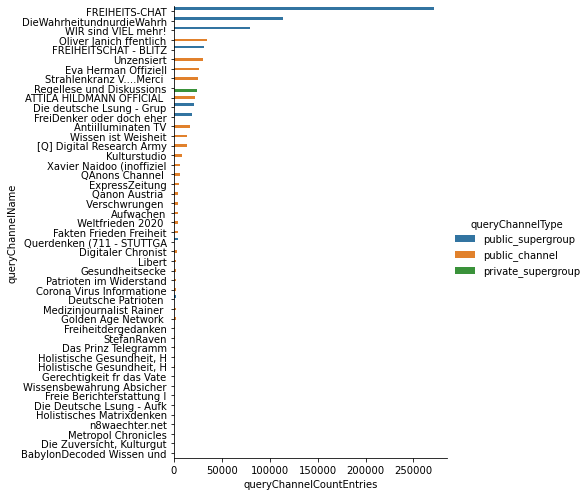

In [32]:
queryPlotter("queryChannelCountEntries")

In [33]:
#queryPlotter("queryChannelPercentRawText")

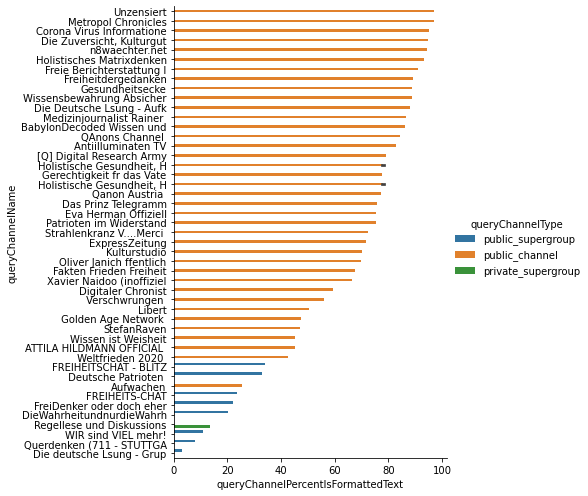

In [34]:
queryPlotter("queryChannelPercentIsFormattedText")

In [35]:
#queryPlotter("queryChannelPercentValidText") 

In [36]:
#queryPlotter("queryChannelPercentPhoto")

In [37]:
#queryPlotter("queryChannelPercentFile")

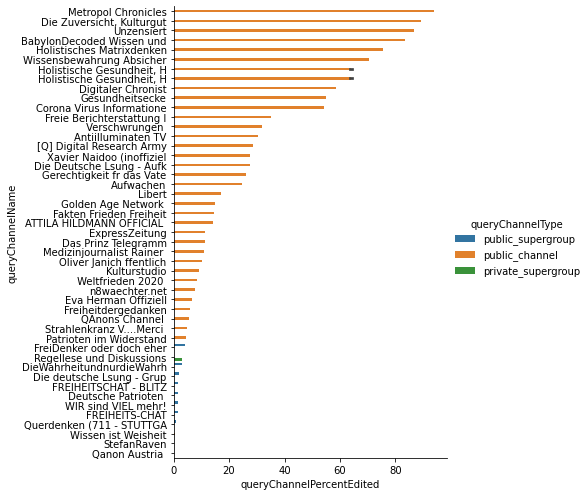

In [38]:
queryPlotter("queryChannelPercentEdited")

## Get valid text

In [39]:
def normalizedValidTextSize(df):
    df = df.copy()
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    return df[np.abs(df.processedValidTextSize-df.processedValidTextSize.mean()) <= (3*df.processedValidTextSize.std())]

Before all filters		831260
Before normalizedValidTextSize	524609
After normalizedValidTextSize	514091


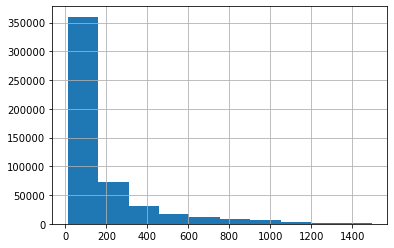

In [40]:
dfMessages = dfAllDataMessages.copy()
print("Before all filters\t\t" + str(len(dfMessages.index)))

dfMessages = dfMessages[dfMessages.processedValidTextSize > 10]
print("Before normalizedValidTextSize\t" + str(len(dfMessages.index)))

dfMessages = normalizedValidTextSize(dfMessages)
print("After normalizedValidTextSize\t" + str(len(dfMessages.index)))

_ = dfMessages.processedValidTextSize.hist()

## Word Clouds

In [41]:
#TODO Difference capital letters?
#TODO Context?

# Use "global" for all DataFrames
def plotChannelWordCloud(filePath, label):
    timeStart = time.time()
    
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    print("[Start transform text to global text string]")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["processedValidText"])
        
    textString = ''.join(textList)
    
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    
    print("[Start generate wordCloud]")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    wordcloud.to_file("wordcloud-" + label + ".png")
    
    print("Top 10 occ:\n" + str(pd.Series(wordcloud.words_).head(10)))
    
    print("[Start generate figure]")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
ja          1.000000
mehr        0.959060
Menschen    0.916104
gibt        0.823233
mal         0.760714
schon       0.739336
immer       0.666431
geht        0.665020
Attila      0.625492
Wer         0.550267
dtype: float64
[Start generate figure]


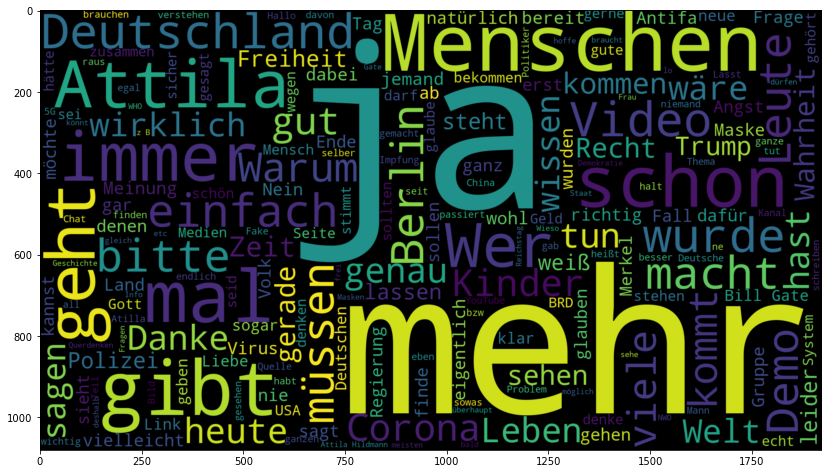

[Finished]
48.948s


In [42]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-28-freiheitsChat", "freiheitsChat")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
mehr           1.000000
wurde          0.919847
Deutschland    0.858355
sei            0.779050
Video          0.648007
sagte          0.627651
Menschen       0.606022
schon          0.546226
gibt           0.542409
Polizei        0.503817
dtype: float64
[Start generate figure]


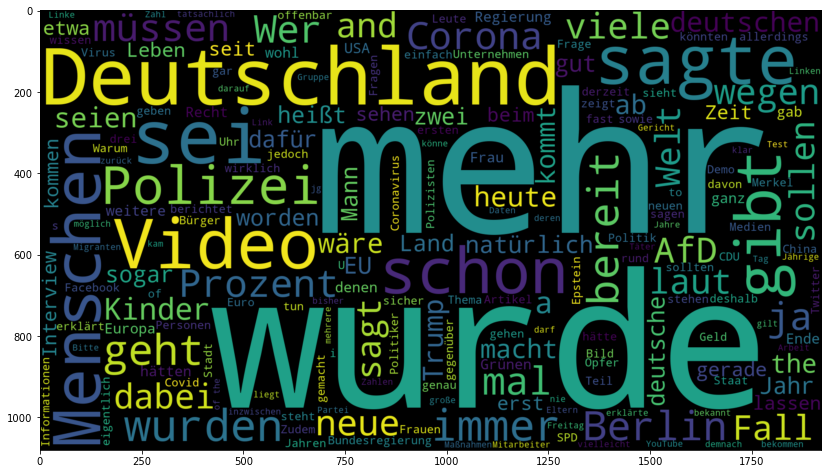

[Finished]
16.164s


In [43]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-janich", "janich")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
mehr           1.000000
Menschen       0.855237
wurde          0.825217
Deutschland    0.644430
gibt           0.566378
heute          0.547698
immer          0.513009
Corona         0.498999
schon          0.490327
sagte          0.488993
dtype: float64
[Start generate figure]


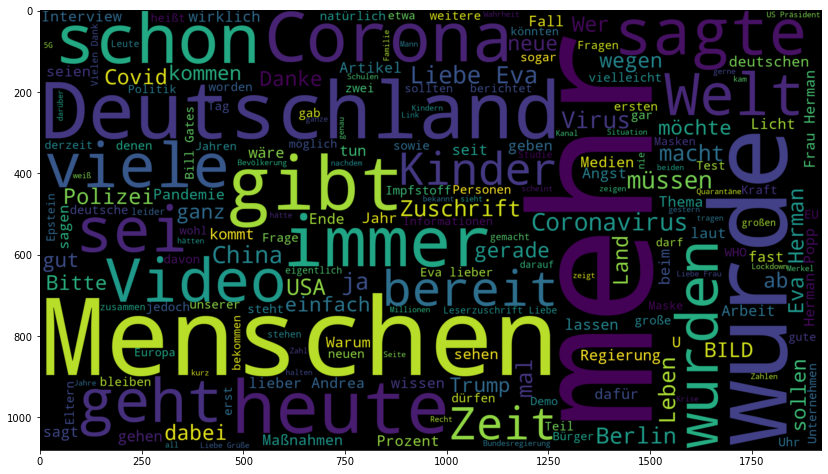

[Finished]
11.480s


In [45]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-27-evaherman", "evaHerman")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
Deutschland            1.000000
Corona                 0.739456
mal                    0.610122
Gate                   0.602624
Merkel                 0.586692
schon                  0.582006
Menschen               0.567010
mehr                   0.546392
WOLF ATTILAHILDMANN    0.488285
China                  0.485473
dtype: float64
[Start generate figure]


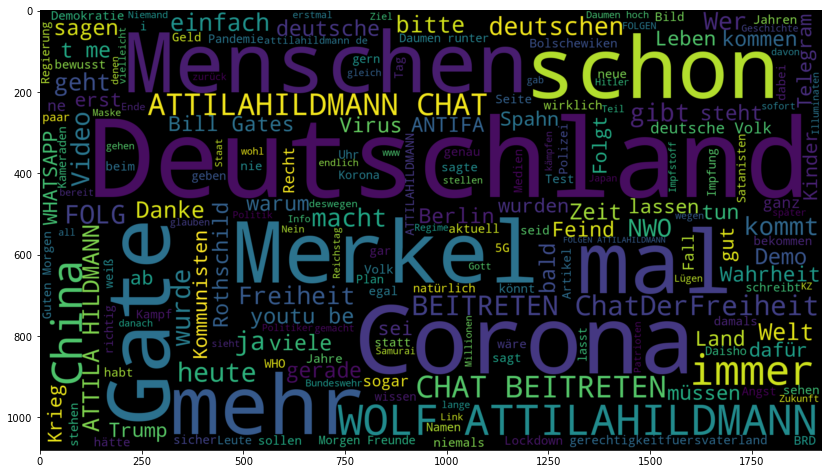

[Finished]
9.687s


In [46]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-hildmann", "hildmann")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
oneLove Xavier_Naidoo    1.000000
xavier_naidoo OneLove    0.432392
Menschen                 0.292719
mehr                     0.291976
wurde                    0.226597
schon                    0.198366
mal                      0.182764
Video                    0.181278
Deutschland              0.177563
Corona                   0.170877
dtype: float64
[Start generate figure]


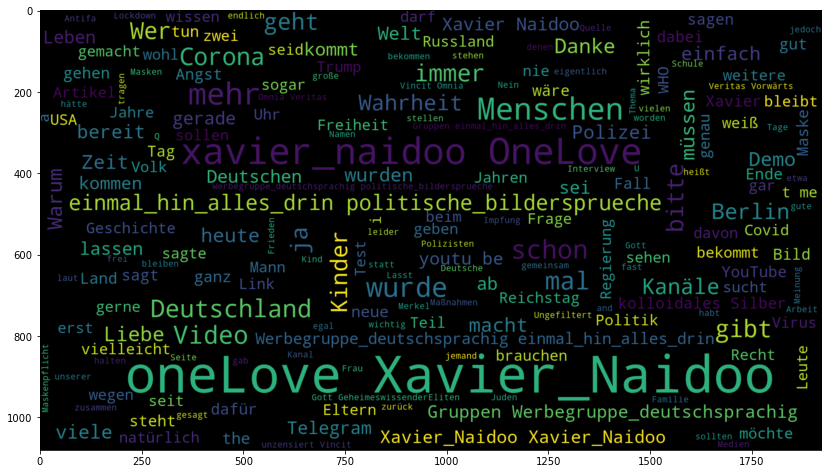

[Finished]
6.940s


In [47]:
plotChannelWordCloud("DS-08-10-2020/ChatExport_2020-09-25-xavier", "xavier")

[Start transform text to global text string]
[Start generate wordCloud]
Top 10 occ:
mehr           1.000000
ja             0.997820
Menschen       0.854742
gibt           0.818805
schon          0.657302
geht           0.653223
Deutschland    0.652941
immer          0.650374
mal            0.604170
wurde          0.572348
dtype: float64
[Start generate figure]


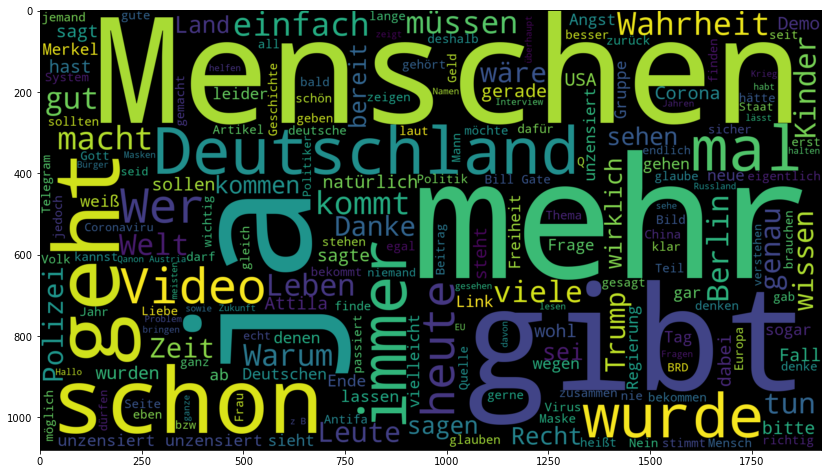

[Finished]
183.402s


In [48]:
plotChannelWordCloud("global", "global")

## Concordance

In [ ]:
#t = nltk.text.Text("Hallo Welt. Was machst du gerade? Das ist nur ein Test! Schöne Welt! Das geht ja gar nicht Welt!")
#t.index("Welt")